In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy
import networkx as nx

# Generating data

In [2]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [3]:
y=(X[:,0]**2 + X[:,1]**2)**.5 < 60

In [4]:
X,X_test,y,y_test = train_test_split(X,y)

In [5]:
X.shape,X_test.shape

((1875, 2), (625, 2))

In [6]:
def PlotData(X,y):
    plt.scatter(x=X[:,0],y=X[:,1],c=y)    

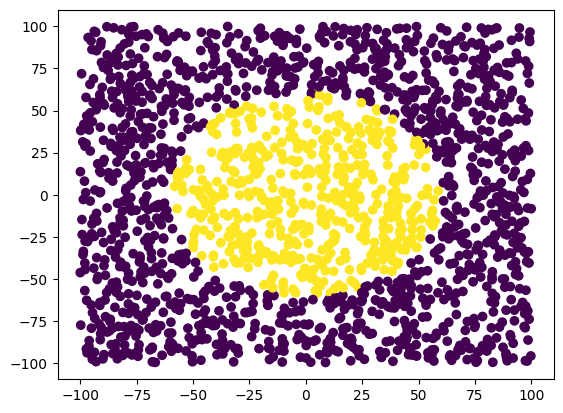

In [7]:
PlotData(X,y)

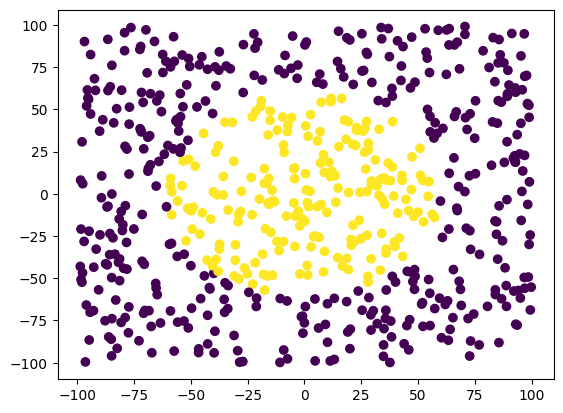

In [8]:
PlotData(X_test,y_test)

# Network Architechture
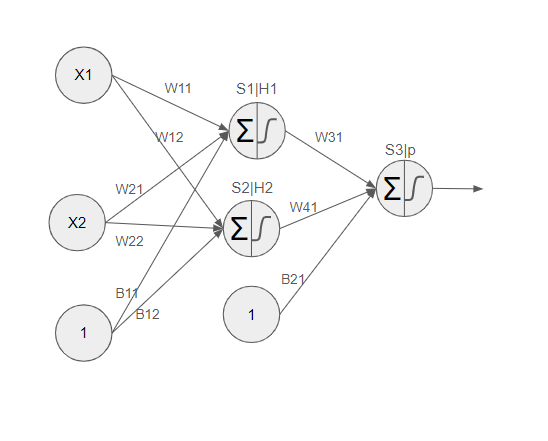

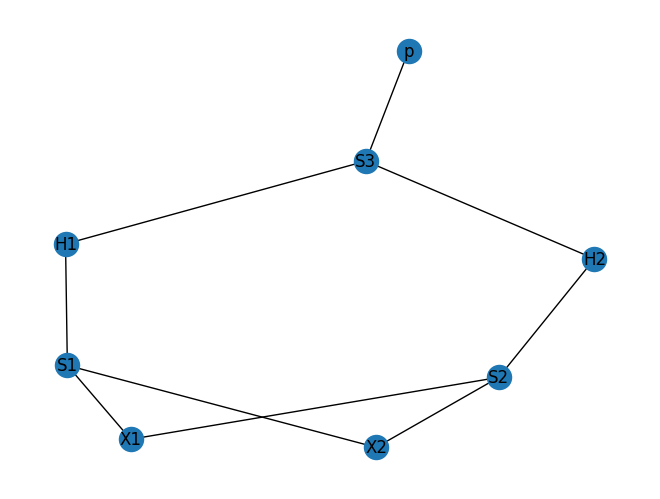

In [9]:
graph = {
    'S1':['X1','X2'],
    'S2':['X1','X2'],
    'H1':['S1'],
    'H2':['S2'],
    'S3':['H1','H2'],
    'p':['S3']
    
}
G = nx.Graph(graph)
nx.draw(G,with_labels=True)

In [515]:
class Σ:
    def __init__(self,In):
        self.In = In
        self.w = numpy.zeros((In.shape[1]+1,1))
        self.b = numpy.ones((In.shape[0],1))
    def eval(self):
        self.out = numpy.c_[self.In,self.b].dot(self.w)
        return self.out
    def prime(self):
        self.pr = numpy.c_[self.In,self.b].mean(axis=0).reshape(-1,1)
        return self.pr
    def update(self,α,Δnext):
        self.Δ = self.prime()*Δnext
        self.w -= α*self.Δ
        return self.Δ

In [525]:
class σ:
    def __init__(self,In=None):
        self.In = In
    def eval(self):
        self.out = [1/(1+numpy.exp(-z)) for z in self.In]
        return self.out
    def prime(self):
        self.p = numpy.array([ (o*(1-o)).sum() for o in self.out]).reshape(-1,1)
        return self.p
    def update(self,α,Δnext):
        self.prime()
        self.Δ = [Δ[:len(self.p),:]*self.p for Δ in Δnext]
        return self.Δ    

In [526]:
class fullyconnected:
    def __init__(self,n_out,In=None,is_input=False):
        self.n_out = n_out
        self.is_input = is_input
        if is_input :  In = Σ(In)
        self.__In = [In]*self.n_out
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        self.__In = [Σ(numpy.concatenate(v,axis=1))]*self.n_out
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [v.eval() for v in self.In]
        return self.out
    def update(self,α,Δnext):
        self.Δ = [ I.update(α,Δnext[0][ix]) for ix,I in enumerate(self.In) ]
        return self.Δ    

# Backpropagation

## Sequential architecture

In [538]:
class Sequential:
    def __init__(self,steps):
        self.steps = steps
    def eval(self):
        print(self.steps[0].In[0].w)
        self.steps[0].eval()
        self.out = self.steps[0].out
        for step in self.steps[1:]:
            step.In = self.out
            step.eval()
            self.out = step.out
        return self.out
    def update(self,α,Δnext):
        for step in self.steps[::-1]:
            Δnext = step.update(α,Δnext)
        return self

In [470]:
Model = Sequential([

        fullyconnected(n_out=20,In=X,is_input=True),
        σ(),

        fullyconnected(n_out=5),
        σ(),

        fullyconnected(n_out=1),
        σ()
    

])

In [471]:
Model.steps

In [235]:
for m in Model.steps[-2::-2]:
    print(m)

In [236]:
len(Model.steps[0])

20

In [237]:
len(Model.steps[2])

5

In [303]:
Model.eval()

[array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]])]

In [239]:
len(Model.steps[0].out)

20

In [240]:
len(Model.steps[1].In)

20

In [241]:
len(Model.steps[1].out)

20

In [242]:
len(Model.steps[2].In)

5

In [243]:
len(Model.steps[2].out)

5

In [244]:
Model.steps[0]

## Cost function

In [436]:
class binaryCrossEntropy:
    def __init__(self,y,p):
        self.y = y
        self.p = p
    def eval(self):
        self.out = -(self.y*numpy.log(self.p) + (1-self.y)*numpy.log(1-self.p)).mean()
        return self.out
    def prime(self):
        self. pr = [-(self.y/self.p - (1-self.y)/(1-self.p)).mean(keepdims=True)]
        return self.pr

In [437]:
C = binaryCrossEntropy(y,Model.out[0])

AttributeError: 'Sequential' object has no attribute 'out'

In [438]:
C.eval()

0.6931471805599468

In [306]:
C.prime()

[array([[0.93973333]])]

## Update weights

In [323]:
C = binaryCrossEntropy(y,Model.out[0])
C.eval()
α = 1e-3
Δnext = C.prime()
Δnext

[array([[0.93973333]])]

In [324]:
Model.steps[-1]

In [325]:
len(Model.steps[-1].In),len(Model.steps[-1].out)

(1, 1)

In [326]:
Model.steps[-1].In[0].shape

(1875, 1)

In [327]:
Model.steps[-1].update(α,Δnext)

[array([[440.5]])]

In [328]:
Δnext = Model.steps[-1].Δ
Δnext

[array([[440.5]])]

In [329]:
Model.steps[-2]

In [330]:
len(Model.steps[-2].In),len(Model.steps[-2].out)

(1, 1)

In [331]:
Model.steps[-2].In[0].In.shape

(1875, 5)

In [332]:
Model.steps[-2].update(α,Δnext)

[array([[220.25],
        [220.25],
        [220.25],
        [220.25],
        [220.25],
        [440.5 ]])]

In [333]:
Δnext = Model.steps[-2].Δ
Δnext

[array([[220.25],
        [220.25],
        [220.25],
        [220.25],
        [220.25],
        [440.5 ]])]

In [334]:
Model.steps[-3]

In [335]:
len(Model.steps[-3].In),len(Model.steps[-3].out)

(5, 5)

In [336]:
Model.steps[-3].In[0].shape

(1875, 1)

In [337]:
Model.steps[-3].update(α,Δnext)

[array([[103242.1875],
        [103242.1875],
        [103242.1875],
        [103242.1875],
        [103242.1875]])]

In [338]:
Δnext = Model.steps[-3].Δ
Δnext

[array([[103242.1875],
        [103242.1875],
        [103242.1875],
        [103242.1875],
        [103242.1875]])]

In [339]:
Model.steps[-4]

In [340]:
len(Model.steps[-4].In),len(Model.steps[-4].out)

(5, 5)

In [341]:
Model.steps[-4].In[0].In.shape

(1875, 20)

In [342]:
Model.steps[-4].update(α,Δnext)

[array([[ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [103242.1875 ]]),
 array([[ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [ 51621.09375],
        [10324

In [343]:
Δnext = Model.steps[-4].Δ
len(Δnext),Δnext[0].shape

(5, (21, 1))

In [344]:
Model.steps[-5]

In [345]:
len(Model.steps[-5].In),len(Model.steps[-5].out)

(20, 20)

In [346]:
Model.steps[-5].In[0].shape

(1875, 1)

In [347]:
Model.steps[-5].update(α,Δnext)

[array([[24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125]]),
 array([[24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.6953125],
        [24197387.

In [348]:
Δnext = Model.steps[-5].Δ
len(Δnext),Δnext[0].shape

(5, (20, 1))

In [349]:
Model.steps[-6]

In [350]:
len(Model.steps[-6].In),len(Model.steps[-6].out)

(20, 20)

In [351]:
Model.steps[-6].In[0].In.shape

(1875, 2)

In [352]:
Model.steps[-6].update(α,Δnext)

[array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6953125 ]]),
 array([[  1744267.73365902],
        [-29171626.72063296],
        [ 24197387.6

In [353]:
Δnext = Model.steps[-6].Δ
len(Δnext),Δnext[0].shape

(20, (3, 1))

In [439]:
Model = Sequential([

        fullyconnected(n_out=20,In=X,is_input=True),
        σ(),

        fullyconnected(n_out=5),
        σ(),

        fullyconnected(n_out=1),
        σ()
    

])

In [440]:
Model.eval()

[array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]])]

In [441]:
C = binaryCrossEntropy(y,Model.out[0]) 
C.eval()
α = 1e-3
Δnext = C.prime()
Δnext

[array([[0.93973333]])]

In [442]:
Model.update(α,Δnext)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.22025]
 [-0.22025]
 [-0.22025]
 [-0.22025]
 [-0.22025]
 [-0.4405 ]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [-103.2421875 ]]
[[ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [ -51.62109375]
 [-103.2421875 ]]
[[-103.2421875]
 [-103.2421875]
 [-103.2421875]

# Training

In [528]:
Model = Sequential([

        fullyconnected(n_out=2,In=X,is_input=True),
        σ(),

        fullyconnected(n_out=1),
        σ()

])
Model.eval()

[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]


[array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]])]

In [529]:
Model.steps[0].In[0].w

array([[0.],
       [0.],
       [0.]])

In [530]:
Model.steps[0].out

[array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])]

In [531]:
n_epochs = 1
α = 1e-1

for n in range(n_epochs):
    print(n)
    C = binaryCrossEntropy(y,Model.eval()[0]) 
    #print(Model.steps[-2].In[0].w)
    print('n=',n,'logloss=',C.eval())
    Model = Model.update(α,C.prime())
    #print(Model.steps[-2].Δ)

0
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]
n= 0 logloss= 0.6931471805599468


In [533]:
Model.steps[0].In[0].w

array([[ -1488.44179939],
       [ 24893.12146827],
       [-20648.4375    ]])

In [534]:
Model.eval()

[[ -1488.44179939]
 [ 24893.12146827]
 [-20648.4375    ]]
[[ -1488.44179939]
 [ 24893.12146827]
 [-20648.4375    ]]
[[ -1488.44179939]
 [ 24893.12146827]
 [-20648.4375    ]]
[[ -1488.44179939]
 [ 24893.12146827]
 [-20648.4375    ]]
[[ -1488.44179939]
 [ 24893.12146827]
 [-20648.4375    ]]


/tmp/ipykernel_13646/3294087953.py:5: RuntimeWarning: overflow encountered in exp
  self.out = [1/(1+numpy.exp(-z)) for z in self.In]


[array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]])]

In [537]:
Model.steps[-2].In[0].w

array([[0.],
       [0.],
       [0.]])

In [536]:
Model.steps[0].out

[array([[-1202720.80398597],
        [ -705529.73379612],
        [  792528.03451499],
        ...,
        [-1030310.7488035 ],
        [-2236864.64590294],
        [ -126302.22186316]]),
 array([[-1202720.80398597],
        [ -705529.73379612],
        [  792528.03451499],
        ...,
        [-1030310.7488035 ],
        [-2236864.64590294],
        [ -126302.22186316]])]

In [491]:
Model.steps[-4].out

[array([[-1202720.80398597],
        [ -705529.73379612],
        [  792528.03451499],
        ...,
        [-1030310.7488035 ],
        [-2236864.64590294],
        [ -126302.22186316]]),
 array([[-1202720.80398597],
        [ -705529.73379612],
        [  792528.03451499],
        ...,
        [-1030310.7488035 ],
        [-2236864.64590294],
        [ -126302.22186316]])]